In [108]:
import numpy as np
import botorch
import torch

torch.set_default_dtype(torch.double)

from botorch.acquisition.analytic import LogExpectedImprovement, UpperConfidenceBound
from botorch.models.transforms.outcome import Standardize 
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize

from gpytorch.kernels import MaternKernel

import torch

from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood

import json
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

In [75]:
synth_data = pd.read_csv('synth_table_with_rmsedist_10_28_24.csv')

In [76]:
synth_data = synth_data[~synth_data['rmse_log_distance'].isna()]

In [110]:
x_data = synth_data[['teos_vol_frac', 'ammonia_vol_frac', 'water_vol_frac', 'ethanol_vol_frac']]
y_data = synth_data['rmse_log_distance']

In [109]:
tsne = TSNE()

In [111]:
x_tsne = tsne.fit_transform(x_data)

Text(0.5, 1.0, 'TSNE plot of initial data')

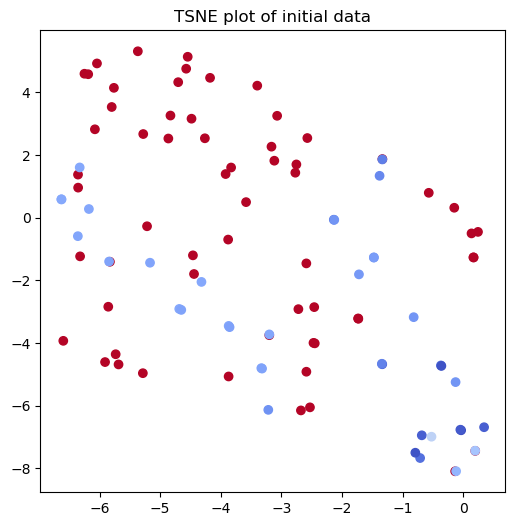

In [116]:
fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(x_tsne[:,0], x_tsne[:,1], c = y_data, cmap = plt.cm.coolwarm)
ax.set_title("TSNE plot of initial data")


## re-assign invalids from 50 to 5
- I have a hunch this will scale better

In [78]:
y_data[y_data ==50] = 5

In [79]:
y_data = (y_data - y_data.min())/(y_data.max() - y_data.min())

In [82]:
y_data

2      0.084666
3      1.000000
4      0.046804
5      1.000000
6      1.000000
         ...   
119    0.227047
120    1.000000
121    1.000000
122    1.000000
123    0.224968
Name: rmse_log_distance, Length: 99, dtype: float64

In [80]:
y_torch = torch.tensor(y_data.to_numpy()).reshape(-1,1)

In [81]:
y_torch.size()

torch.Size([99, 1])

In [66]:

x_torch = torch.tensor(x_data.to_numpy())

In [83]:
x_torch

tensor([[0.0118, 0.0376, 0.0288],
        [0.1064, 0.0053, 0.1340],
        [0.0588, 0.0306, 0.0088],
        [0.1242, 0.0071, 0.0359],
        [0.0594, 0.0588, 0.0194],
        [0.0135, 0.0194, 0.0112],
        [0.0229, 0.0806, 0.1094],
        [0.0406, 0.0112, 0.0194],
        [0.0112, 0.0283, 0.0942],
        [0.0535, 0.0082, 0.0711],
        [0.0471, 0.0218, 0.0235],
        [0.0371, 0.0618, 0.0683],
        [0.0465, 0.0376, 0.1388],
        [0.0194, 0.0864, 0.0811],
        [0.0188, 0.0765, 0.0524],
        [0.0553, 0.0318, 0.0765],
        [0.0206, 0.0682, 0.0805],
        [0.1311, 0.0059, 0.0805],
        [0.0882, 0.0188, 0.0918],
        [0.1082, 0.0453, 0.0112],
        [0.0894, 0.0312, 0.0600],
        [0.0370, 0.0488, 0.0705],
        [0.0688, 0.0658, 0.0764],
        [0.0494, 0.0453, 0.0794],
        [0.0641, 0.0059, 0.0553],
        [0.1300, 0.0394, 0.0912],
        [0.0524, 0.0929, 0.1194],
        [0.0235, 0.0177, 0.0465],
        [0.0335, 0.0482, 0.1094],
        [0.081

## Set up model

In [98]:
nu = 5/2

In [99]:
kernel = MaternKernel(nu = nu
gp_model = SingleTaskGP(x_torch, y_torch, outcome_transform=Standardize(m=1), covar_module=kernel, )

mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)

In [100]:
fit_gpytorch_mll(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): LogNormalPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
  )
)

In [105]:
mll

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): LogNormalPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
  )
)

In [101]:
posterior = gp_model.posterior(x_torch)

In [102]:
mean = posterior.mean.detach().reshape(-1).tolist()

In [103]:
mean

[0.21933741240322824,
 0.8709985076899073,
 0.2598691475920524,
 0.8020983166703581,
 0.7031584323720895,
 0.5511440495876234,
 0.6078877229318624,
 0.4294555531163895,
 0.15034620973830826,
 0.1917102807364527,
 0.270239201601278,
 0.7265863399320939,
 0.4070228781344764,
 0.29893485910812184,
 0.30791285292435217,
 0.7451711562398363,
 0.26166071809899044,
 0.5374440617266351,
 0.2696589083128884,
 0.9114912182487735,
 0.31663651082662025,
 0.7729065600717446,
 1.077904671385869,
 0.9270222803390206,
 0.1329660811145812,
 0.9310718701407126,
 0.9693278361992341,
 0.238671603899831,
 0.4027526047324687,
 0.986619934727889,
 0.289109346095268,
 1.0078025039433895,
 0.9285834463156772,
 0.6412989579383293,
 0.16850818120501687,
 0.9949592081266788,
 1.0442893054123803,
 0.5534055885232328,
 0.6112000462110949,
 0.9791145484899504,
 0.9953792790539597,
 0.8965166288726191,
 1.024689163993851,
 0.426719826822281,
 0.15128683884493843,
 0.7919638571375169,
 0.188337778874077,
 0.9859846250

Text(0, 0.5, 'GPR fit')

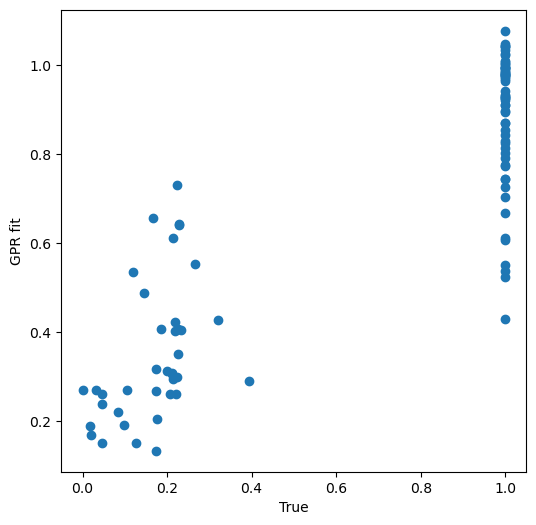

In [107]:

fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(y_data, mean)
ax.set_xlabel('True')
ax.set_ylabel('GPR fit')


In [ ]:
tsne.fit(